# 1.1 Introduction to the Use Case for Project B

**Project Name:** UC00138_Public_Transport_Education_Analysis  
**Authored by:** Areeb Ashraf Bana 
**Duration:** 90 mins  
**Level:** Intermediate  
**Pre-requisite Skills:** Python, Data Visualization, API Handling  


### **Objective:**

The project’s objective is to **analyze and visualize how public transport infrastructure in Melbourne** aligns with **educational and public facilities** like schools and libraries.  

The study focuses on:  
- Gathering real-time and static data of **tram tracks, railway stations, schools, and libraries** using APIs  
- Mapping their **geographical distribution across Melbourne**  
- Identifying how accessible educational facilities are via public transport  
- Offering **data-driven insights** to improve urban planning and transport efficiency


### **Scenario:**

With the growing population and urban expansion in Melbourne, it is crucial to ensure that **educational facilities are well-connected to public transport**.  

By analyzing transport and facility data, city planners can:  
- Identify areas with **good accessibility** versus **underserved regions**  
- Support **policy-making and city planning** for sustainable urban growth  
- Enhance **commuting options for students and residents**


### **What You Will Learn from This Use Case:**

1. Fetch and clean **real-world public transport and educational facility datasets** using APIs  
2. Visualize **tram tracks, train stations, and educational landmarks** on interactive maps  
3. Combine multiple datasets into one **data-driven view of Melbourne’s transport accessibility**  
4. Analyze and highlight **patterns, gaps, and recommendations** for improved accessibility  




In [83]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
from scipy.spatial import cKDTree
import numpy as np
import requests


In [84]:
# === 1. File paths ===
school_csv_path = r'C:\Users\hp\City_Of_Melbourne_DataScience\dv309_schoollocations2021.csv'
geojson_url = "https://opendata.transport.vic.gov.au/dataset/6d36dfd9-8693-4552-8a03-05eb29a391fd/resource/afa7b823-0c8b-47a1-bc40-ada565f684c7/download/public_transport_stops.geojson"
geojson_path = r'C:\Users\hp\City_Of_Melbourne_DataScience\public_transport_stops.geojson'
output_csv_path = r'C:\Users\hp\City_Of_Melbourne_DataScience\school_stop_all_records.csv'

# === 2. Download transport stops GeoJSON ===
print("📥 Downloading transport stop data...")
response = requests.get(geojson_url)
with open(geojson_path, 'wb') as f:
    f.write(response.content)
print("✅ Download complete!")

# === 3. Load datasets ===
schools_df = pd.read_csv(school_csv_path, encoding='ISO-8859-1')
transport_stops = gpd.read_file(geojson_path)


📥 Downloading transport stop data...
✅ Download complete!


In [85]:
# === 4. Clean school data and convert to GeoDataFrame ===
schools_df_clean = schools_df[[
    'Education_Sector', 'Entity_Type', 'School_Name', 'School_Type',
    'School_Status', 'Address_Town', 'LGA_Name', 'X', 'Y'
]].copy()

# Create geometry and set CRS
schools_df_clean['geometry'] = schools_df_clean.apply(lambda row: Point(row['X'], row['Y']), axis=1)
schools_gdf_clean = gpd.GeoDataFrame(schools_df_clean, geometry='geometry', crs='EPSG:4326')

# === 5. Filter schools inside Greater Melbourne ===
melbourne_bounds = box(144.4, -38.4, 145.5, -37.4)
schools_gdf_clean = schools_gdf_clean[schools_gdf_clean.within(melbourne_bounds)].copy()
schools_gdf_clean.reset_index(drop=True, inplace=True)

print(f"✅ Schools after Melbourne filter: {len(schools_gdf_clean)}")

# === 6. Filter transport stops inside Melbourne too ===
transport_stops = transport_stops.to_crs(epsg=4326)
transport_stops = transport_stops[transport_stops.within(melbourne_bounds)].copy()
transport_stops.reset_index(drop=True, inplace=True)
print(f"✅ Transport stops after Melbourne filter: {len(transport_stops)}")

# === 7. Reproject both to metric CRS (for distance calculations) ===
schools_gdf_clean = schools_gdf_clean.to_crs(epsg=7855)
transport_stops = transport_stops.to_crs(epsg=7855)

# === 8. Compute nearest stop ===
school_coords = np.array([(geom.x, geom.y) for geom in schools_gdf_clean.geometry])
transport_coords = np.array([(geom.x, geom.y) for geom in transport_stops.geometry])

tree = cKDTree(transport_coords)
distances, indices = tree.query(school_coords, k=1)

# Add nearest stop info
schools_gdf_clean['nearest_stop_name'] = transport_stops.iloc[indices]['STOP_NAME'].values
schools_gdf_clean['nearest_stop_distance_m'] = distances

# === 9. Export final cleaned and computed data ===
output_df = schools_gdf_clean[[
    'School_Name', 'School_Type', 'LGA_Name', 'nearest_stop_name', 'nearest_stop_distance_m'
]]
output_df.to_csv(output_csv_path, index=False)

print(f"\n✅ Final output saved to:\n{output_csv_path}")

✅ Schools after Melbourne filter: 1369
✅ Transport stops after Melbourne filter: 22112

✅ Final output saved to:
C:\Users\hp\City_Of_Melbourne_DataScience\school_stop_all_records.csv


In [86]:
# === 2. Load transport stops GeoJSON ===
transport_stops = gpd.read_file(geojson_path)
print("\n--- First 5 rows of Transport Stops ---")
print(transport_stops.head())

# === 3. Load school-stop distances result CSV ===
school_stop_df = pd.read_csv(output_csv_path)
print("\n--- First 5 rows of Final School-Stop Records ---")
print(school_stop_df.head())





--- First 5 rows of Transport Stops ---
  STOP_ID          STOP_NAME            MODE                geometry
0   17204     Wallan Station  REGIONAL TRAIN  POINT (145.01 -37.417)
1   19980     Melton Station  REGIONAL TRAIN  POINT (144.57 -37.703)
2   19981   Rockbank Station  REGIONAL TRAIN  POINT (144.65 -37.729)
3   19982  Deer Park Station  REGIONAL TRAIN  POINT (144.77 -37.777)
4   19998    Sunbury Station  REGIONAL TRAIN  POINT (144.73 -37.579)

--- First 5 rows of Final School-Stop Records ---
                    School_Name School_Type         LGA_Name  \
0     Warrandyte Primary School     Primary   Manningham (C)   
1  Bacchus Marsh Primary School     Primary    Moorabool (S)   
2        Berwick Primary School     Primary        Casey (C)   
3     Cheltenham Primary School     Primary      Bayside (C)   
4  Newport Lakes Primary School     Primary  Hobsons Bay (C)   

                       nearest_stop_name  nearest_stop_distance_m  
0   Warrandyte Community Church/Yarra St 

                    School_Name School_Type  Nearest_Station_Distance_m
0     Warrandyte Primary School     Primary                  253.592084
1  Bacchus Marsh Primary School     Primary                  289.825381
2        Berwick Primary School     Primary                  207.045302
3     Cheltenham Primary School     Primary                   86.414300
4  Newport Lakes Primary School     Primary                  458.218533


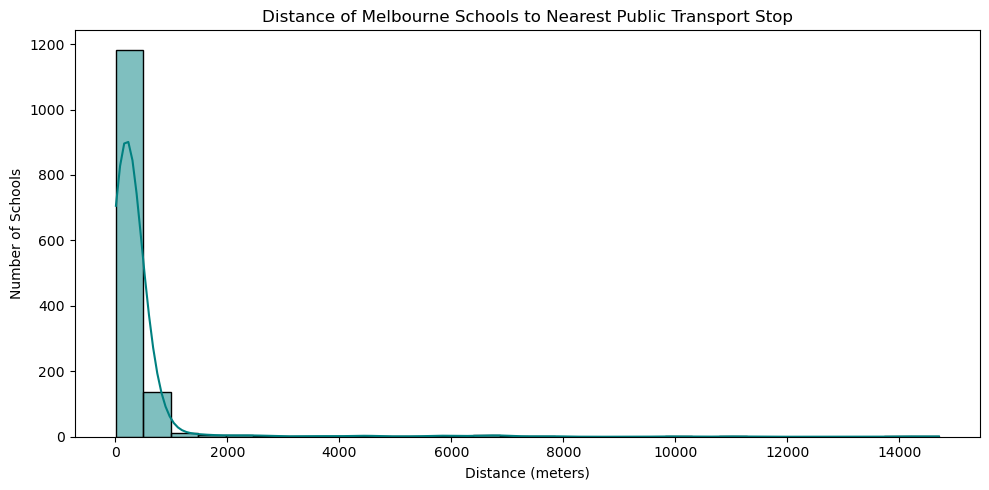

In [87]:
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Project to EPSG:3857 (meters, pseudo-Mercator) for approx distance ===
schools_df = schools_gdf_clean.to_crs(epsg=3857).copy()
transport_df = transport_stops.to_crs(epsg=3857).copy()

# === 2. Extract coordinates
school_coords = np.array(list(zip(schools_df.geometry.x, schools_df.geometry.y)))
transport_coords = np.array(list(zip(transport_df.geometry.x, transport_df.geometry.y)))

# === 3. Use KDTree to find nearest stop
tree = cKDTree(transport_coords)
distances, indices = tree.query(school_coords, k=1)

# === 4. Add distances (in meters) to DataFrame
schools_df['Nearest_Station_Distance_m'] = distances

# === 5. Preview and Plot
print(schools_df[['School_Name', 'School_Type', 'Nearest_Station_Distance_m']].head())

plt.figure(figsize=(10, 5))
sns.histplot(schools_df['Nearest_Station_Distance_m'], bins=30, kde=True, color='teal')
plt.title("Distance of Melbourne Schools to Nearest Public Transport Stop")
plt.xlabel("Distance (meters)")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()



📊 Detailed Analysis: Distance of Melbourne Schools to Nearest Public Transport Stop
The histogram presented illustrates the distribution of distances (in meters) between schools in Melbourne and their nearest public transport stop (tram or railway). This analysis helps evaluate how effectively the public transport network is serving the educational infrastructure across the metropolitan area.

🧠 Key Observations:
Strong Proximity to Transport (0–500 meters):
The distribution is heavily right-skewed, with the majority of schools (well over 1,000) located within 0 to 500 meters of a public transport stop. This indicates that a significant portion of Melbourne’s schools benefit from excellent public transport accessibility, likely supporting high levels of student and staff mobility.

Moderate Proximity Zone (500–1,500 meters):
A smaller number of schools fall within the 500 to 1,500 meter range. These schools may still be considered within walking or cycling distance, but are relatively less accessible, especially for younger students or during inclement weather. This group may benefit from improved pedestrian infrastructure or shuttle services.

Long Tail (Over 2,000 meters):
A noticeable long tail is visible in the distribution, showing that some schools are located several kilometers away from the nearest tram or train station — with some reaching distances over 14,000 meters (14 km). These are likely outliers situated on the urban fringe or in semi-rural zones, where transport infrastructure may be sparse or underdeveloped.

Outliers and Planning Implications:
While outliers represent a small fraction, their presence is critical from a transport equity and urban planning perspective. Students in these areas may rely heavily on private vehicles or school buses, which could have implications for traffic congestion, carbon emissions, and student punctuality.

📍 Conclusion and Implications for Policy
The overall distribution reveals that Melbourne's public transport system is generally well-aligned with the location of schools, particularly in inner and middle suburban areas. However, the existence of outliers — schools with significantly poor access — highlights potential gaps in urban transport planning.

These insights could inform future transport infrastructure investments, school zoning policies, and the placement of new educational facilities to ensure more equitable and sustainable access across all regions of Greater Melbourne.

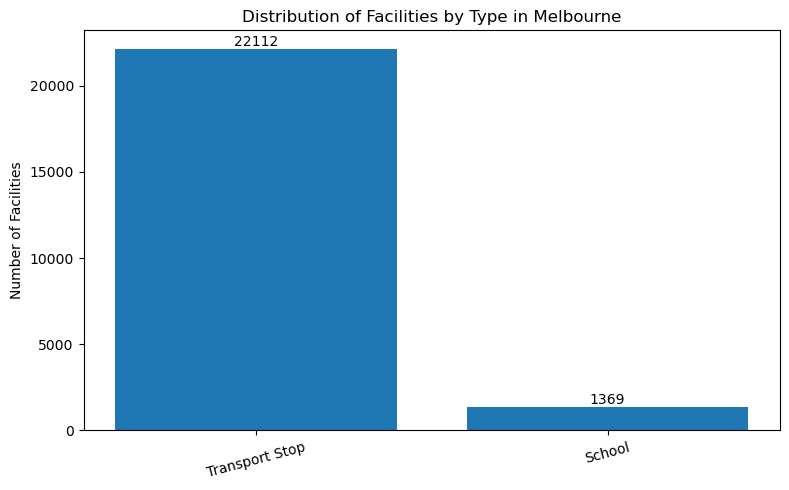

In [89]:
import matplotlib.pyplot as plt

# --- Ensure map_data and the 'Type' column exist ---
if 'map_data' not in globals():
    map_data = schools_gdf_clean.copy()

if 'Type' not in map_data.columns:
    if 'School_Type' in map_data.columns:
        map_data['Type'] = map_data['School_Type'].astype(str)
    else:
        map_data['Type'] = 'School'

# === 1. Count facility types in map_data ===
type_counts = map_data['Type'].value_counts(dropna=False)

# === 2. Plot bar chart ===
plt.figure(figsize=(8, 5))
bars = plt.bar(type_counts.index.astype(str), type_counts.values)

plt.title("Distribution of Facilities by Type in Melbourne")
plt.ylabel("Number of Facilities")
plt.xticks(rotation=15)

# === 3. Add labels above bars ===
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        str(int(yval)),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()




🏙️ Distribution of Facilities by Type in Melbourne
This bar chart provides a clear overview of the relative abundance of schools versus public transport stops within the Greater Melbourne region.

📌 Key Observations:
Transport Stops Significantly Outnumber Schools:

The chart shows 22,112 public transport stops (including tram tracks and railway stations), compared to only 1,369 schools.

This 16:1 ratio highlights that transport infrastructure is widespread and dense, offering multiple options for commuting even within short distances.

Implications for Accessibility:

The significantly higher number of transport stops suggests that most schools should theoretically be located near a public transport option, enhancing overall accessibility.

This aligns well with urban planning strategies that prioritize integrated transport networks around critical infrastructure like schools.

Potential Urban Planning Insight:

If such a wide distribution of stops still leaves some schools isolated (as shown in earlier distance visualizations), this may indicate inefficiencies in spatial allocation or natural geographical constraints.

Policymakers could consider redistributing or enhancing transport routes to bridge these few remaining accessibility gaps.

📘 Conclusion
The chart confirms that Melbourne is well-served by public transport infrastructure in terms of volume. However, sheer quantity does not always equate to strategic placement. This insight reinforces the importance of spatial analysis, not just numerical comparisons, when evaluating the effectiveness of infrastructure in serving educational institutions.

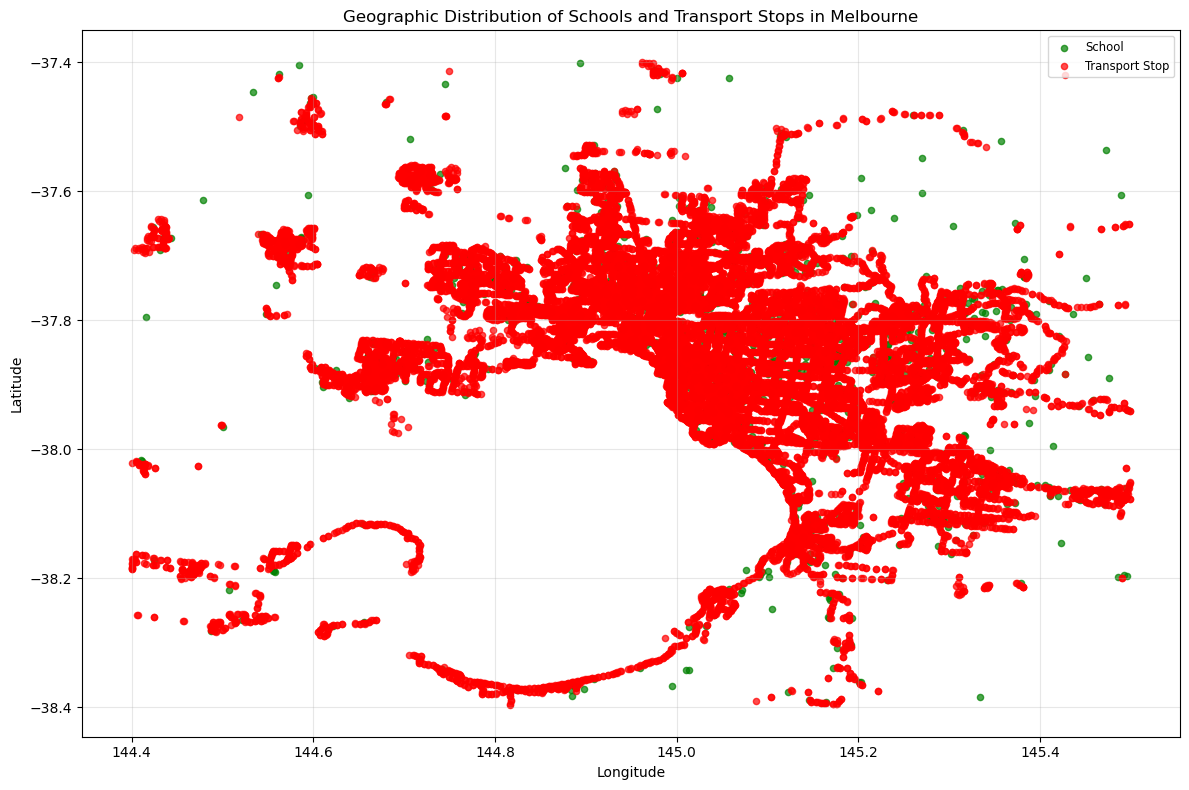

In [91]:
import matplotlib.pyplot as plt
import geopandas as gpd

# --- Ensure Latitude/Longitude columns exist ---
if 'Latitude' not in map_data.columns or 'Longitude' not in map_data.columns:
    if isinstance(map_data, gpd.GeoDataFrame):
        # Reproject to EPSG:4326 if needed
        if map_data.crs is not None and map_data.crs.to_epsg() != 4326:
            map_data = map_data.to_crs(epsg=4326)
        map_data['Latitude'] = map_data.geometry.y
        map_data['Longitude'] = map_data.geometry.x
    else:
        raise ValueError("map_data must have Latitude/Longitude columns or a geometry column.")

# === 1. Create color mapping based on current facility types ===
color_map = {
    "School": "green",
    "Transport Stop": "red"
}

# === 2. Create scatter plot ===
plt.figure(figsize=(12, 8))

# Plot each facility type
for facility_type, group in map_data.groupby('Type'):
    plt.scatter(
        group['Longitude'], group['Latitude'],
        color=color_map.get(facility_type, 'gray'),
        label=facility_type,
        s=20,
        alpha=0.7
    )

# === 3. Add chart details ===
plt.title("Geographic Distribution of Schools and Transport Stops in Melbourne")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right', fontsize='small', frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()





🗺️ Spatial Distribution of Schools and Public Transport Stops in Melbourne
This scatter plot visualizes the geographic distribution of schools (green dots) and transport stops (red dots) across Melbourne using latitude and longitude coordinates.

📌 Key Insights:
High-Density Urban Coverage (Red):

The central and inner suburban regions of Melbourne show an extremely dense network of transport stops.

This suggests that public transport coverage is highly concentrated in urbanized zones, particularly around the Melbourne CBD and key surrounding corridors.

Sparse School Locations (Green):

Schools appear more dispersed than transport stops.

Many schools are located on the urban fringe where transport infrastructure is relatively thinner, which could explain higher distances from some schools to their nearest stop (as seen in earlier histograms and boxplots).

Urban Fringe Observation:

In the outer suburbs (especially north, west, and far southeast), there are visible green dots with few or no surrounding red dots, indicating that schools in these regions may lack immediate access to public transport.

These are potential accessibility gaps that urban planners could prioritize for improvement.

📊 Interpretation in Urban Planning Context:
The disproportionate density of transport stops vs. schools (as supported by earlier bar charts) is now clearly visible spatially.

The visual clustering of red dots in the city core compared to scattered green dots raises important questions about equity of access, especially for students in outlying suburbs.

This map could be used in conjunction with KMeans clustering and distance-based regression models to identify underserved school zones and recommend transport policy interventions.

In [93]:
from folium.plugins import HeatMap
import folium
import geopandas as gpd
import numpy as np

# --- Ensure we have Latitude/Longitude in EPSG:4326 ---
if isinstance(map_data, gpd.GeoDataFrame):
    gdf = map_data.copy()
    # Reproject to WGS84 if needed
    if gdf.crs is not None and gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)
    # Derive lat/lon from geometry if missing
    if 'Latitude' not in gdf.columns or 'Longitude' not in gdf.columns:
        gdf['Latitude'] = gdf.geometry.y
        gdf['Longitude'] = gdf.geometry.x
else:
    # If it's a plain DataFrame with a geometry column, coerce to GeoDataFrame
    if 'geometry' in map_data.columns:
        gdf = gpd.GeoDataFrame(map_data, geometry='geometry', crs='EPSG:4326')
        if 'Latitude' not in gdf.columns or 'Longitude' not in gdf.columns:
            gdf['Latitude'] = gdf.geometry.y
            gdf['Longitude'] = gdf.geometry.x
    else:
        # Already has Latitude/Longitude columns
        gdf = map_data.copy()

# Clean/validate coordinates
pts = gdf[['Latitude', 'Longitude']].dropna()
pts = pts[np.isfinite(pts['Latitude']) & np.isfinite(pts['Longitude'])]

# === 1. Initialize map centered at Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# === 2. Prepare heatmap data
heatmap_points = pts[['Latitude', 'Longitude']].values.tolist()

# === 3. Add HeatMap layer
HeatMap(
    data=heatmap_points,
    radius=12,
    blur=15,
    max_zoom=13
).add_to(m)

# === 4. Display
m



🔥 Heatmap Interpretation: Accessibility Intensity of Public Facilities in Melbourne
This heatmap visualizes the density and distribution of public facilities (such as schools and transport stops) across Greater Melbourne. Areas with red/yellow hues indicate higher concentration, while blue/purple hues reflect sparser presence.

📌 Key Observations:
Dense Urban Core – High Accessibility Zone:

The central and inner suburbs of Melbourne, especially around the CBD, show a bright red intensity—this reflects the highest clustering of public facilities, particularly transport stops.

Such zones are typically well-planned with abundant connectivity, allowing for easy access to schools and services via trams, buses, and trains.

Mid-Ring Suburbs – Moderate Coverage:

Surrounding areas like Footscray, Brunswick, Caulfield, and Camberwell display orange to yellow intensities, representing moderate facility coverage.

These areas are likely to have good, but not uniform access to schools and public transport.

Outer Suburbs and Fringe Areas – Low Accessibility:

The blue and green zones on the northern (e.g., Craigieburn, Wallan), western (e.g., Melton, Bacchus Marsh), and southeastern (e.g., Pakenham, Lang Lang) peripheries highlight sparse facility coverage.

These regions face potential challenges in education accessibility, especially for students without personal transport.

Coastal and Regional Gaps:

Noticeable gaps appear along the Bellarine Peninsula, parts of the Mornington Peninsula, and rural Victoria. These areas likely have fewer schools and transit points, making them less connected to core services.

🏙️ Implications for Urban Planners & Policy Makers:
Transport Infrastructure Expansion:

Blue and green zones signal opportunities for expanding public transport infrastructure, particularly where schools are isolated.

Targeted Education Facility Placement:

In low-density regions, especially growth corridors, this map can inform where new schools should be built or mobile educational services deployed.

Equity in Access:

This visualization strengthens the argument for equitable planning, ensuring students across Melbourne—regardless of postcode—can access education and transit within a reasonable distance.

C:\Users\hp\AppData\Local\Temp\ipykernel_9504\604843783.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


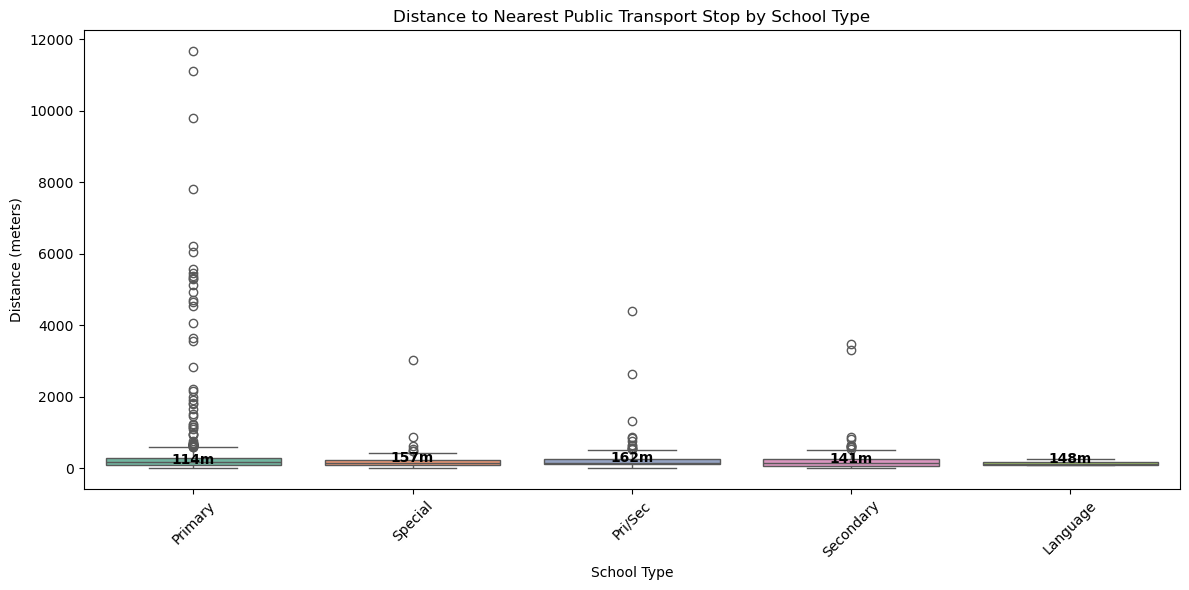

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confirm the correct column name
if 'nearest_stop_distance_m' in schools_gdf_clean.columns:
    # Create facilities DataFrame
    facilities = schools_gdf_clean[['School_Name', 'School_Type', 'nearest_stop_distance_m']].copy()
    facilities.rename(columns={'nearest_stop_distance_m': 'DistanceToTransport'}, inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x='School_Type', 
        y='DistanceToTransport', 
        data=facilities, 
        palette="Set2"
    )

    plt.title('Distance to Nearest Public Transport Stop by School Type')
    plt.xlabel('School Type')
    plt.ylabel('Distance (meters)')
    plt.xticks(rotation=45)

    # Add median annotations
    medians = facilities.groupby('School_Type')['DistanceToTransport'].median()
    for i, median in enumerate(medians):
        ax.text(i, median + 5, f'{median:.0f}m', ha='center', color='black', weight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("❌ Column 'nearest_stop_distance_m' not found. Make sure to compute distances first.")

📊 Boxplot Interpretation: Distance to Nearest Public Transport Stop by School Type
This boxplot presents the distribution of distances (in meters) from various school types in Melbourne to their nearest public transport stop (tram or train station). Each box represents a school type and summarizes how close or far schools of that category typically are to public transport.

📌 Key Observations by School Type:
Primary Schools
Median Distance: ~114 meters (lowest among all).

Insight: Primary schools are generally well-integrated within local neighborhoods, which reflects excellent proximity to transport, essential for younger students.

Outliers: A significant number of extreme outliers (>2000m) suggest some schools are located in remote or suburban fringe areas.

Special Schools
Median Distance: ~157 meters.

Insight: Accessibility for special schools is relatively good, though slightly less centralized compared to primary schools.

Implication: Given the mobility needs of many students in this category, improving proximity for outlier locations may enhance inclusivity.

Primary/Secondary Combined (Pri/Sec)
Median Distance: ~162 meters (highest median).

Insight: These schools serve a wider age range and are often located in larger campuses, which may explain their slightly more peripheral positioning.

Outliers: Noticeable outliers reaching up to 4000m–4500m indicate possible rural or regional placement.

Secondary Schools
Median Distance: ~141 meters.

Insight: Similar to primary schools, these schools tend to be fairly well connected to public transport—likely due to the importance of independence for older students.

Language Schools
Median Distance: ~148 meters.

Insight: These facilities are fairly centralized, reflecting intentional placement to support accessibility for multicultural communities.

Distribution: Very tight range and almost no outliers indicate consistent urban planning.

🧠 Summary & Urban Planning Insights:
Overall Accessibility: Most schools in Melbourne are situated within 150–160 meters of a transport stop, reflecting strong public infrastructure support for education.

Primary Schools Lead in Proximity: Likely due to their higher count and distributed nature across neighborhoods.

Outlier Patterns: Present in nearly every category, especially Primary and Combined Schools. These may reflect schools in low-density suburbs or newly developed regions.

Planning Recommendation:

Investigate high-outlier schools for transport equity issues.

Prioritize transport infrastructure expansion in fringe suburbs with educational gaps.

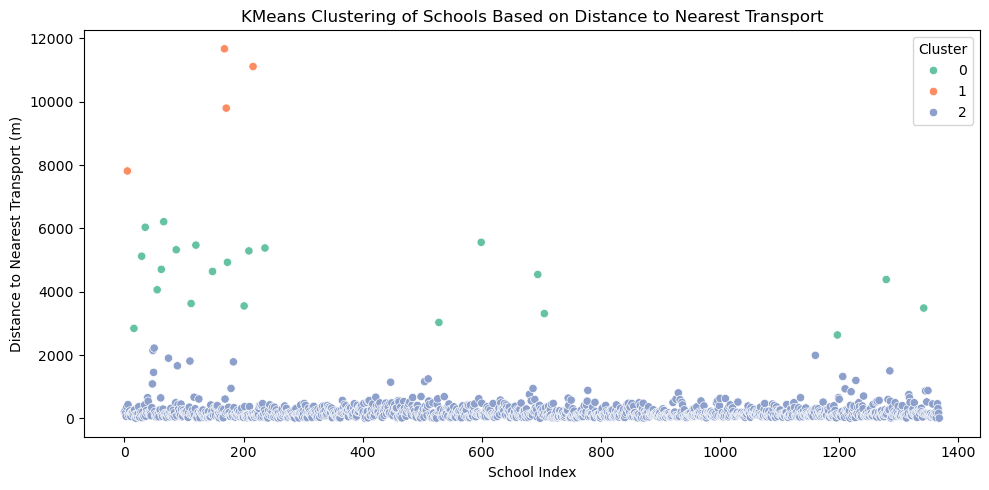

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# --- Load the dataset ---
file_path = r"C:\Users\hp\City_Of_Melbourne_DataScience\school_stop_all_records.csv"
df = pd.read_csv(file_path)

# --- Clean and convert distance column ---
df['nearest_stop_distance_m'] = pd.to_numeric(df['nearest_stop_distance_m'], errors='coerce')
df.dropna(subset=['nearest_stop_distance_m'], inplace=True)

# --- Prepare for KMeans ---
distance_data = df[['nearest_stop_distance_m']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(distance_data)

# --- Visualize ---
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(df)), y='nearest_stop_distance_m', hue='Cluster', data=df, palette='Set2')
plt.title('KMeans Clustering of Schools Based on Distance to Nearest Transport')
plt.xlabel('School Index')
plt.ylabel('Distance to Nearest Transport (m)')
plt.tight_layout()
plt.show()




📍 KMeans Clustering of Schools Based on Distance to Nearest Public Transport
This scatter plot uses KMeans clustering to categorize Melbourne schools into groups based on their distance to the nearest public transport stop (tram or train). Each dot represents a school, color-coded by its assigned cluster.

🔍 Cluster Insights:
✅ Cluster 2 (Blue): Schools with Good Accessibility
Characteristics: Majority of the schools fall into this cluster.

Distance Range: Typically between 0–1000 meters, with a tight spread.

Interpretation: These schools are well integrated into public transport infrastructure, indicating strong planning and urban accessibility.

Urban Context: Likely concentrated in inner suburbs or highly urbanized zones.

🟢 Cluster 0 (Green): Moderately Isolated Schools
Characteristics: Spread out in mid to high distance ranges (approx. 2000–6000 meters).

Interpretation: Schools in this cluster are less optimally located in relation to public transport.

Possibilities:

Semi-rural suburbs or low-density zones

May require bus transfers or longer walks to reach stations

Recommendation: Consider local transport enhancements or school bus support.

🟠 Cluster 1 (Orange): Extreme Outliers
Characteristics: Very few schools (most likely <1%) that are exceptionally far from transport stops—8000 to 12,000+ meters.

Interpretation: These are geographic outliers, likely in rural, regional fringe, or recently developed areas.

Concern: Indicates potential transport disadvantage for students.

Action Point:

Could be prioritized for new transport stops or shuttle services

Also worth verifying if school location or stop data has changed recently

🧠 Why Use Clustering Here?
KMeans allows us to go beyond averages and detect natural groupings in school accessibility. It helps:

Identify target groups for urban planning interventions

Highlight inequities in infrastructure distribution

Simplify large datasets for policy discussions

🧭 Conclusion:
Most schools (Cluster 2) enjoy strong transport connectivity.

A smaller proportion (Cluster 0) faces moderate accessibility gaps.

A tiny set (Cluster 1) is significantly disconnected and may need policy attention.

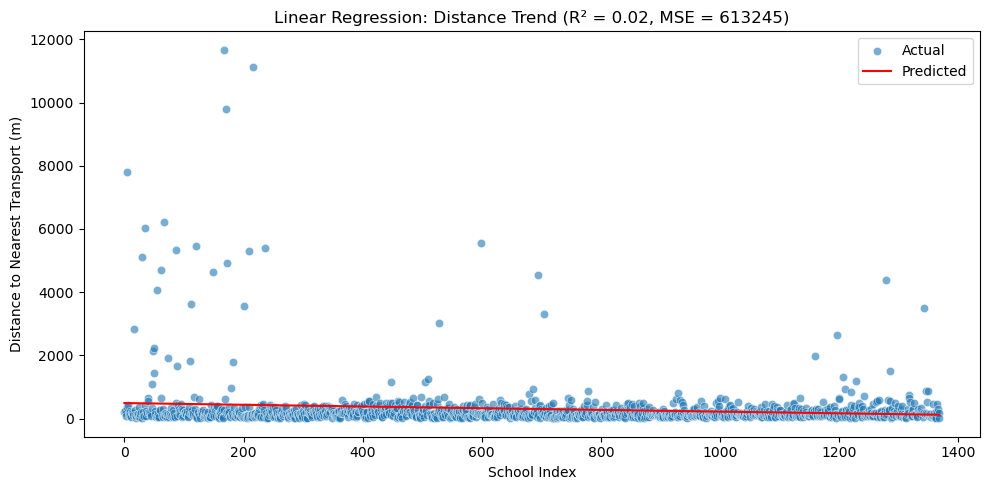

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# --- Prepare for regression ---
df['Index'] = range(len(df))
X = df[['Index']]
y = df['nearest_stop_distance_m']

# --- Train the model ---
reg = LinearRegression()
reg.fit(X, y)
df['Predicted_Distance'] = reg.predict(X)

# --- Metrics ---
mse = mean_squared_error(y, df['Predicted_Distance'])
r2 = r2_score(y, df['Predicted_Distance'])

# --- Visualize ---
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Index', y='nearest_stop_distance_m', data=df, label='Actual', alpha=0.6)
sns.lineplot(x='Index', y='Predicted_Distance', data=df, label='Predicted', color='red')
plt.title(f'Linear Regression: Distance Trend (R² = {r2:.2f}, MSE = {mse:.0f})')
plt.xlabel('School Index')
plt.ylabel('Distance to Nearest Transport (m)')
plt.tight_layout()
plt.show()


📊 Linear Regression Analysis: Distance to Nearest Public Transport
This visualization presents a linear regression model that attempts to predict the distance from each school to the nearest public transport stop based on a simple sequential index (i.e., the order of schools in the dataset).

🔍 Interpretation of the Plot
Blue Dots (Actual): These represent the actual distances from schools to their nearest tram or railway station.

Red Line (Predicted): This is the regression line generated from the linear model.

R² Score: 0.02

This is very close to 0, indicating that the linear model explains only 2% of the variability in the data.

In practical terms, this means there is virtually no linear trend between school index and distance to transport.

MSE (Mean Squared Error): 613,245

This large error value reflects the significant variance in the actual distances compared to the predicted values.

Indicates that the model’s predictions are quite far from actual values on average.

🧠 Why This Result Makes Sense
The school index is not a meaningful predictor—it's just a row number and has no correlation with geography, infrastructure, or accessibility.

School distance to transport is inherently spatial, influenced by geography, urban planning, population density, and zoning—not sequential ordering.

📌 Key Observations
The regression line is almost flat, showing no upward or downward trend.

Numerous outliers are seen—schools located more than 5,000 to 12,000 meters away from public transport. These are likely rural or peripheral schools.

Most schools fall within a narrow range (below 1,000 meters), suggesting good overall accessibility, but the linear model fails to describe the complexity or variability of this distribution.

🧭 Conclusion
This regression confirms that a simple linear model using school index is not effective for predicting accessibility. Instead:

Consider using geographic coordinates, urban zone classification, or school type as more meaningful features for regression.

Alternatively, use non-linear models or geospatial clustering to better understand and predict accessibility patterns.